### 1) Duplicate content detection on Screaming Frog Data With Shingling

* pip install nltk
   * After installing open python and type:
   * import nltk
   * nltk.download()
   * Load stopwords corpus.
* pip install mmh3
* pip install pandas
* pip install matplotlib

### 2) Here we import the required libraries
If you get an error here most likely you don't have the right version of Python, or one of the modules is not installed. Python should tell you you are missing a module and you can most often just type "!pip install [modulename]"

In [1]:
import mmh3
from nltk import ngrams
import pandas
import random
import matplotlib.pyplot as plt

### 3) Load in the data. 
The data can be loaded from Screeaming Frog > internal_html.csv export after crawling a site with an extraction set to pull all text from the main content body element using XPATH or CSS Selectors. If loaded correctly you should see the columns and top five rows below when running this cell. You can use another tool to pull site content, but will need to use csv format and ensure the content column is named "Column 1" and the associated URL column is named "Address".


In [2]:
in_file = "Data 7999 for Shingling.csv"
df = pandas.read_csv(in_file)
df = df[df['Body'] == df['Body']]
df.reset_index(drop=True, inplace=True)
df.head()

,ReviewID,MemberID,Verified,RealName,ReviewOrder,ProductID,Date,Rating,HelpfulFeedbacks,Feedbacks,Title,Body
0,528306,A1FVW47U1G96QV,0,1,5,B000EPAP1U,11/17/2007,5,1,1,Easy To Use!,This ends the problems with having different c...
1,528307,A1PC9DN6CJH4E9,0,0,6,B000EPAP1U,4/2/2007,5,3,3,Great product,I have this phone for a laboratory with multip...
2,528308,A38QEATH3NODFM,0,0,7,B000EPAP1U,11/2/2006,5,7,7,An excellent value for four handsets. So far c...,I just got this set and have been messing arou...
3,528309,A1F7SX3GNVBNE3,0,1,8,B000EPAP1U,5/16/2006,4,14,14,Great value but some useability issues.,I bought the Uniden DCT646-4 2.4 GHz Digital E...
4,528310,A3M3W5P5TPO1EC,0,0,1,B000EP1IL6,4/13/2006,1,9,27,SONYS GETTING CHEAPER!!!!,YOUR GONNA NEED DIGITAL CABLE TO USE ALL THE F...


### 5) These are functions that we will use.
Code for shingling taken from https://github.com/steven-s/text-shingles

In [3]:
def generate_random_seeds(n, seed=5):
    random.seed(seed)
    return random.sample(range(1, n+1), n)

def jaccard_similarity(set_a, set_b):
    return len(set_a.intersection(set_b)) / len(set_a.union(set_b))


class ShingledText:
    def __init__(self, text, random_seed=5, shingle_length=5, minhash_size=200):
        split_text = text.split()
        if len(split_text) < shingle_length:
            raise ValueError(u'input text is too short for specified shingle length of {}'.format(shingle_length))

        self.minhash = []
        self.shingles = ngrams(split_text, shingle_length)

        for hash_seed in generate_random_seeds(minhash_size, random_seed):
            min_value = float('inf')
            for shingle in ngrams(split_text, shingle_length):
                value = mmh3.hash(' '.join(shingle), hash_seed)
                min_value = min(min_value, value)
            self.minhash.append(min_value)

    def similarity(self, other_shingled_text):
        return jaccard_similarity(set(self.minhash), 
                set(other_shingled_text.minhash))
    
def apply_shingled(row, df, df_shingled):
    
    idx = row.name
    high = 0.0
    match = ""
    start = 0.0
    
    for i, s in enumerate(df_shingled):
        if i > len(df):
            print('i',i)
        if idx > len(df):
            print('idx',idx)
                
        if not i == idx:
            sim = df_shingled[idx].similarity(df_shingled[i])
            if sim > high:
                high = sim
                match = str(df['Body'][i])
    
    row['Sim Score'] = high
    row['Sim Match'] = match
        
    return row

    

### 6) Build a list of shingled text
We only want to do this one time as it takes time and we will have to re-iterate over every row to find the closest match.

In [4]:
df_shingled = []

# Build content shingles list
for i, row in df.iterrows():
    
    text = row['Body']
    
    if isinstance(text, str) and len(text.split()) > 5:  
        df_shingled.append(ShingledText(text))
    else:
        df_shingled.append(False)
        

    

### 9) Apply similarity values and most similar url to dataframe

In [5]:
df_comp = df.apply(apply_shingled, args=(df, df_shingled), axis=1)
df_comp.head(5)

AttributeError: ("'bool' object has no attribute 'minhash'", 'occurred at index 0')

### 10) Visualize your duplicate content. >.6 Should be reviewed.  1 are exact duplicates.

In [8]:
import numpy as numpy

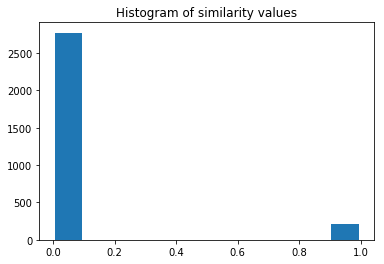

In [9]:
sims = df_comp['Sim Score'].tolist()
a = numpy.histogram(sims)
plt.hist(sims, bins=10, rwidth= .9)  # arguments are passed to np.histogram
plt.title("Histogram of similarity values")
plt.show()

### 11) Save to a file

In [10]:
#df_comp.head()
fn1 = 'sim_data_out_7999.csv'
df_comp.to_csv(fn1, encoding='utf-8' )